In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

ImportError: cannot import name 'NaT' from 'pandas._libs' (unknown location)

In [5]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,hour_sin,hour_cos,minute_sin,minute_cos
0,23.18,27.2720,721.25,1,0,-0.965926,-0.258819,-0.809017,0.587785
1,23.15,27.2675,714.00,1,0,-0.965926,-0.258819,-0.809017,0.587785
2,23.15,27.2450,713.50,1,0,-0.965926,-0.258819,-0.669131,0.743145
3,23.15,27.2000,708.25,1,0,-0.965926,-0.258819,-0.587785,0.809017
4,23.10,27.2000,704.50,1,0,-0.965926,-0.258819,-0.500000,0.866025


In [9]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

26
2
32


In [11]:
df_test.shape

(7625, 5)

In [12]:
# Splitting into X and y
X_train = df_train.drop('Occupancy', axis=1).values
y_train = df_train['Occupancy'].values
X_val = df_val.drop('Occupancy', axis=1).values
y_val = df_val['Occupancy'].values
X_test = df_test.drop('Occupancy', axis=1).values
y_test = df_test['Occupancy'].values

In [13]:
# Scaling the data:
# For continues columns like Temperature, Humidity, I will use StandardScaler
# to avoid from outliers effect.
# For minute and hour columns, I will use MinMaxScaler, because they are bounded. 
# While I was researching about this, there was another option, which is sin and cos encoding for cyclical features.


# Column index for minute and hour
time_columns = [2, 3]
# First and second columns are continuous
continuous_columns = [0, 1]

# Scaling oonly first two columns
scaler = StandardScaler()
X_train[:, continuous_columns] = scaler.fit_transform(X_train[:, continuous_columns])
X_test[:, continuous_columns]  = scaler.transform(X_test[:, continuous_columns])
X_val[:, continuous_columns]  = scaler.transform(X_val[:, continuous_columns])

time_scaler = MinMaxScaler()
X_train[:, time_columns] = time_scaler.fit_transform(X_train[:, time_columns])
X_test[:, time_columns]  = time_scaler.transform(X_test[:, time_columns])
X_val[:, time_columns]  = time_scaler.transform(X_val[:, time_columns])
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Shapes: (9249, 4) (2526, 4) (7625, 4)


In [14]:
# MAKING SEQUENCES:
# Since The CNN needs sequences to capture the relevant patterns

window_size = 20
# I need to create a function for making windows
def time_windows(X, y, window_size, step_ahead = 1):
    # Creating two list for features and labels
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size - step_ahead + 1):
        X_windows.append(X[i:i+window_size])
        # so the next step after the window must be predicted
        # if window_size from 0 to 60, the next step is 60
        y_windows.append(y[i+window_size-1 + step_ahead])
    return np.array(X_windows), np.array(y_windows)
# Applying the function:
X_train, y_train = time_windows(X_train, y_train, window_size)
X_val, y_val = time_windows(X_val, y_val, window_size)
X_test, y_test = time_windows(X_test, y_test, window_size)

print('Training sequences shape:', X_train.shape)
print('Training class shape:', y_train.shape)
print('Example  X:', X_train[0])
print("Example  y:", y_train[0])
# I got the code structure from here:
# https://stackoverflow.com/questions/77812013/pandas-dataframe-to-sliding-window

Training sequences shape: (9229, 20, 4)
Training class shape: (9229,)
Example  X: [[0.72887849 0.32646912 0.60869565 0.81355932]
 [0.7582453  0.2927464  0.60869565 0.83050847]
 [0.73866743 0.32372993 0.60869565 0.84745763]
 [0.73866743 0.32372993 0.60869565 0.86440678]
 [0.7582453  0.32646912 0.60869565 0.86440678]
 [0.72887849 0.35850735 0.60869565 0.89830508]
 [0.7582453  0.34269943 0.60869565 0.91525424]
 [0.7582453  0.39223007 0.60869565 0.93220339]
 [0.7582453  0.37305064 0.60869565 0.93220339]
 [0.7582453  0.40993495 0.60869565 0.96610169]
 [0.7582453  0.42553294 0.60869565 0.96610169]
 [0.7582453  0.43817927 0.60869565 0.98305085]
 [0.7582453  0.39265246 0.65217391 0.        ]
 [0.7582453  0.39202014 0.65217391 0.01694915]
 [0.7582453  0.41920977 0.65217391 0.03389831]
 [0.78761212 0.41920977 0.65217391 0.05084746]
 [0.78761212 0.41225428 0.65217391 0.06779661]
 [0.85613469 0.44450244 0.65217391 0.06779661]
 [0.7582453  0.43185611 0.65217391 0.10169492]
 [0.78761212 0.47738292 0

In [15]:
# The occupancy is imbalanced, So I will compute the class weights

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
Class_weight = dict(zip(classes, weights))
Class_weight

{0: 0.6373618784530387, 1: 2.320010055304173}

In [16]:
model = Sequential([
    Conv1D(64, 5, padding='same', input_shape=(window_size, X_train.shape[2]), kernel_regularizer=l2(0.0002)),
    BatchNormalization(), Activation('relu'),
    SpatialDropout1D(0.25),
    MaxPooling1D(2),

    Conv1D(128, 7, padding='same'),
    BatchNormalization(), Activation('relu'),
    SpatialDropout1D(0.25),

    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0002)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])
model.summary()

d:\ML&DE\Deep_Learning\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 20, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 10, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,737 (299.75 KB)

 Trainable params: 76,097 (297.25 KB)

 Non-trainable params: 640 (2.50 KB)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, verbose=1)

In [19]:
history = model.fit(X_train, y_train, 
    epochs=50, batch_size=128, callbacks=[early_stop, reduce_lr], class_weight=Class_weight,
    validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
73/73 - 2s - 32ms/step - accuracy: 0.7636 - loss: 0.5167 - precision: 0.4749 - val_accuracy: 0.8508 - val_loss: 0.6110 - val_precision: 0.8094 - learning_rate: 5.0000e-04
Epoch 2/50
73/73 - 0s - 5ms/step - accuracy: 0.8308 - loss: 0.3918 - precision: 0.5644 - val_accuracy: 0.8619 - val_loss: 0.4679 - val_precision: 0.8065 - learning_rate: 5.0000e-04
Epoch 3/50
73/73 - 0s - 5ms/step - accuracy: 0.8503 - loss: 0.3486 - precision: 0.5971 - val_accuracy: 0.8855 - val_loss: 0.4318 - val_precision: 0.8057 - learning_rate: 5.0000e-04
Epoch 4/50
73/73 - 0s - 6ms/step - accuracy: 0.8607 - loss: 0.3286 - precision: 0.6161 - val_accuracy: 0.8851 - val_loss: 0.3152 - val_precision: 0.8335 - learning_rate: 5.0000e-04
Epoch 5/50
73/73 - 0s - 5ms/step - accuracy: 0.8601 - loss: 0.3101 - precision: 0.6138 - val_accuracy: 0.9194 - val_loss: 0.2636 - val_precision: 0.8888 - learning_rate: 5.0000e-04
Epoch 6/50
73/73 - 0s - 5ms/step - accuracy: 0.8699 - loss: 0.2955 - precision: 0.6332 - val_a

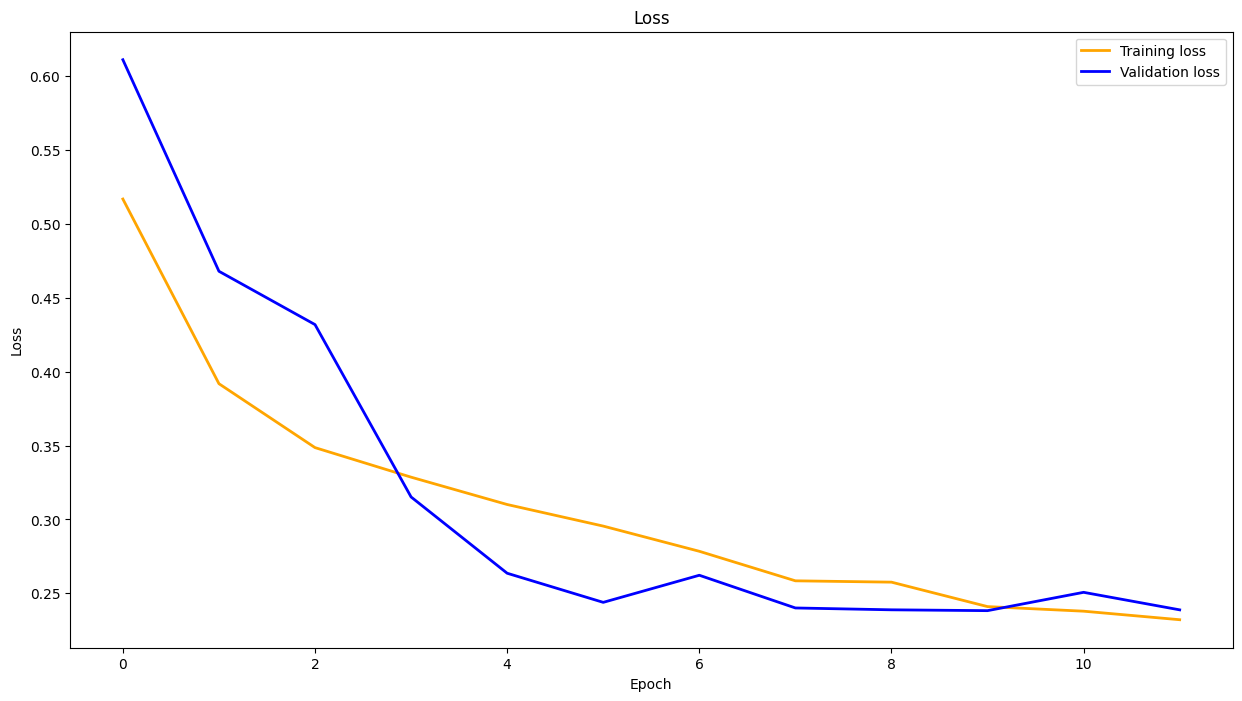

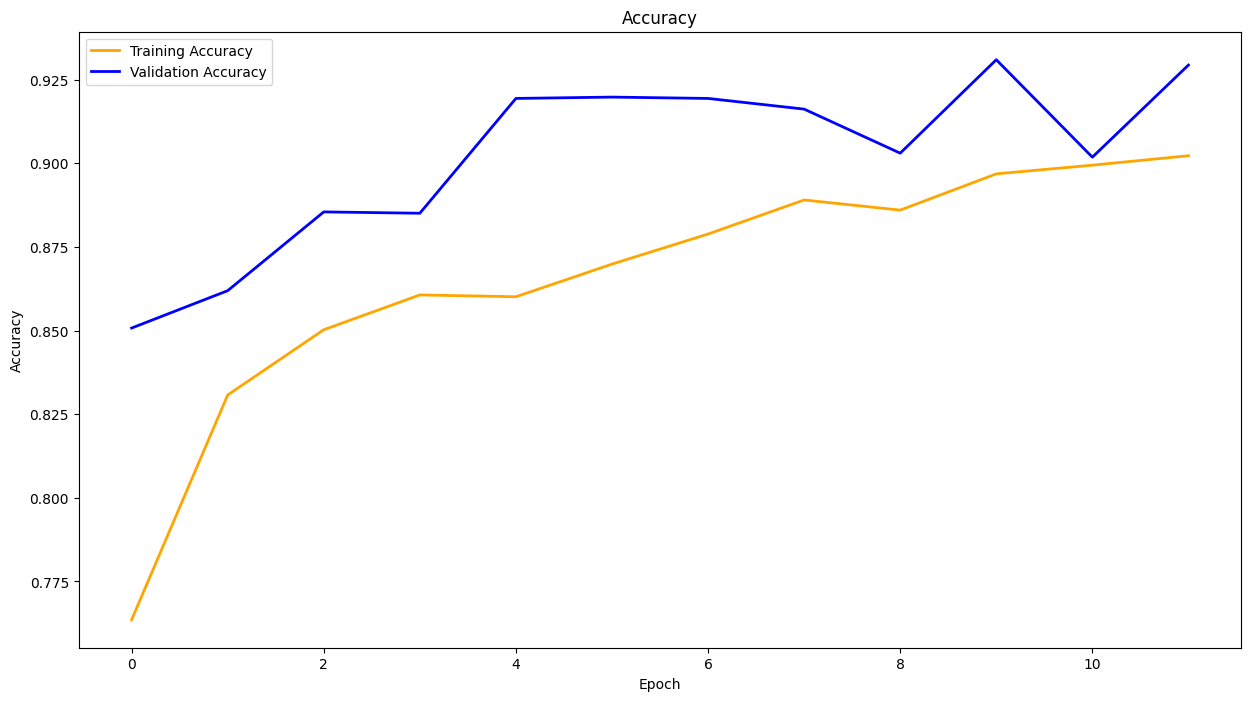

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['accuracy'], label='Training Accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


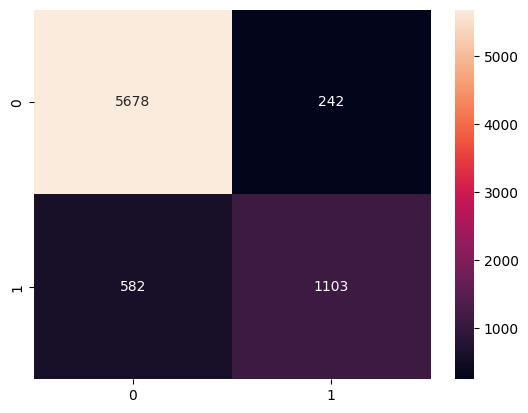

In [21]:
# Predict on test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
Confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(Confusion_matrix, annot=True, fmt='d')
plt.show()

In [22]:
# Classification report
print(classification_report(y_test, y_pred))

# Model has good overall accuracy, but what I can see that for 1 class the precision is low

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      5920
           1       0.82      0.65      0.73      1685

    accuracy                           0.89      7605
   macro avg       0.86      0.81      0.83      7605
weighted avg       0.89      0.89      0.89      7605

